In [1]:
# Reload dependencies upon changes
%load_ext autoreload
%autoreload 2

In [2]:
from functools import partial
import typing
import sys

import numpy as np
import gym
import tqdm
import matplotlib.pyplot as plt

from mazelab_experimenter import EnvRegister
from mazelab_experimenter import AgentShelve
from mazelab_experimenter import evaluate, GenericOuterHook, benchmark
from mazelab_experimenter.utils import find

In [59]:
name_gridworld = EnvRegister.register(
    maze_type='gridworld', 
    name=f'gridworld_hierq-v0', 
    env_args=dict(
        shortest_path_rewards=True, track_states=True
    ),
    generator_args=dict(height=12, width=12),
    initialization_args=dict(
        start_pos=[[1, 1]], goal_pos=[[10, 10]]
    ),
    time_limit=1000,
    override=True
)

env = gym.make(name_gridworld)


agent = AgentShelve.retrieve(
    agent='HierQ',
    keyword_arguments=dict(
        observation_shape=env.observation_space.shape,
        n_actions=env.action_space.n,
        n_levels=2,
        horizons=[3, 200],
        lr=0.8, discount=0.997, epsilon=0.25
    ))
agent.set_goal(agent._get_index(env.unwrapped.maze.get_end_pos()[0]))

In [63]:
agent.train(env, 100, True)

HierQ Training: 100%|███████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 118.00it/s]


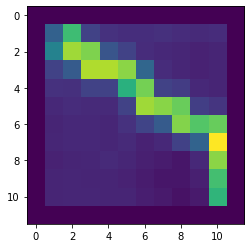

In [68]:
plt.imshow(np.sum(env.unwrapped.state_count_memory, axis=0))

In [66]:
env.unwrapped.state_count

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 1., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 2., 1., 1., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 1., 2., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])